<a href="https://colab.research.google.com/github/vernon-chang/Design-and-Development-of-Autoencoders-to-Identify-Latent-Space-for-Protein-Dynamics/blob/main/peptide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the data and import the necessary packages

In [ ]:
import h5py
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import time 

drive.mount('/content/drive')
f = h5py.File('/content/drive/MyDrive/fs_peptide.h5', 'r')
analysis = np.array(f['analysis']['full_cmaps'])
unique_map = np.unique(analysis, axis=0)

Mounted at /content/drive


In [ ]:
unique_map[30]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

# **The CVAE model of peptide data set**

(16, 2)
Tensor("sequential_1/conv2d_transpose_2/BiasAdd:0", shape=(16, 21, 21, 1), dtype=float32)


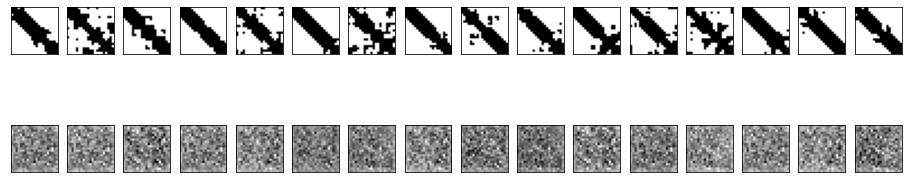

(100, 2)
Tensor("sequential_1/conv2d_transpose_2/BiasAdd:0", shape=(100, 21, 21, 1), dtype=float32)
Epoch: 10, Test set ELBO: -78.17867279052734, time elapse for current epoch 358.2160212993622


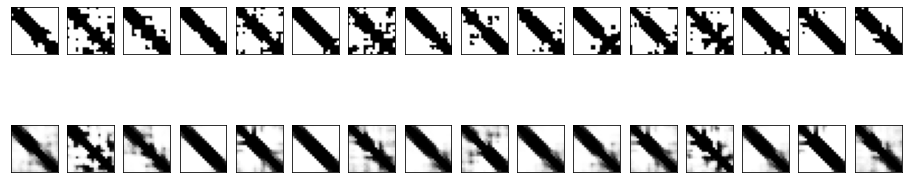

Epoch: 20, Test set ELBO: -74.80343627929688, time elapse for current epoch 353.9733850955963


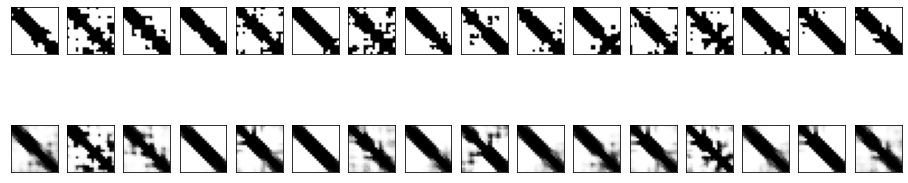

Epoch: 30, Test set ELBO: -72.83367919921875, time elapse for current epoch 353.9131796360016


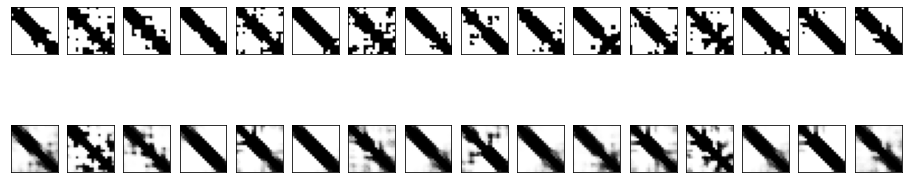

Epoch: 40, Test set ELBO: -71.38849639892578, time elapse for current epoch 353.9226641654968


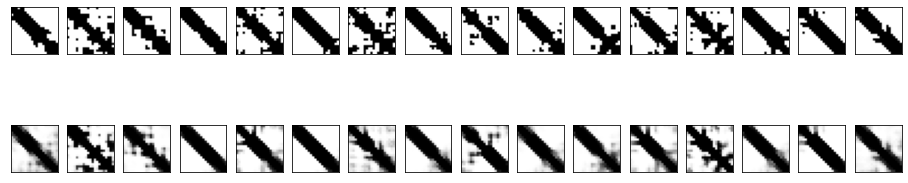

Epoch: 50, Test set ELBO: -70.61888122558594, time elapse for current epoch 364.9374644756317


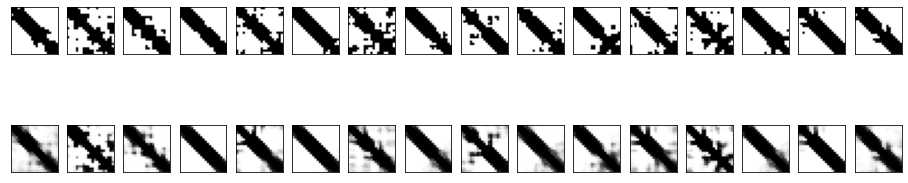

Epoch: 60, Test set ELBO: -69.93922424316406, time elapse for current epoch 363.5712082386017


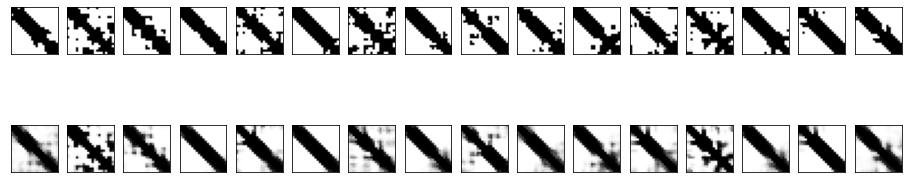

In [ ]:
#reshape the data set
train, test = train_test_split(analysis, test_size = 0.3)
train = train.reshape(train.shape[0], 21, 21, 1).astype('float32')
test = test.reshape(test.shape[0], 21, 21, 1).astype('float32')
BATCH_SIZE = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(train.shape[0]).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test).shuffle(test.shape[0]).batch(BATCH_SIZE)

#create the model
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(21,21,1)),
          tf.keras.layers.Conv2D(
              filters=18, kernel_size=3, strides=3, activation='relu'),
          tf.keras.layers.Conv2D(
              filters=36, kernel_size=3, strides=3, activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=21*21*18, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(21, 21, 18)),
          tf.keras.layers.Conv2DTranspose(
              filters=36,
              kernel_size=3,
              strides=1,
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=18,
              kernel_size=3,
              strides=1,
              padding="SAME",
              activation='relu'),
          # No activation
           tf.keras.layers.Conv2DTranspose(
               filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    print(z.shape)
    logits = self.generative_net(z)
    print(logits)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits


optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

#the loss function
@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
    
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  
epochs = 100
latent_dim = 2
num_examples_to_generate = 16

# Keep the random vector constant for generation (prediction) to make it easier to see improvements.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)


def generate_and_save_images(model, epoch, test_sample):
  # Reconstruction
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(20, 4))
    for i in range(predictions.shape[0]):
            # display original
        ax = plt.subplot(2, 20, i + 1)
        test_sample = np.array(test_sample)
        plt.imshow(test_sample[i].reshape(21,21))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

            # display reconstruction
        ax = plt.subplot(2, 20, i + 1 + 20)
        plt.imshow(predictions[i,:,:,0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

generate_and_save_images(model, 0, test_sample)
losses = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 10 == 0:
    loss = tf.keras.metrics.Mean()
    
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    losses.append(loss.result()) 
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, test_sample)
    
#plot the loss function image
t = np.arange(0,epoch,1)
plt.plot(t, losses)

# **The AAE model of peptide data set**

In [ ]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers.advanced_activations import LeakyReLU

# -------------------------------------------------------------------------------------------------------------
# Set random seed
tf.random.set_seed(50)
np.random.seed(50)

# -------------------------------------------------------------------------------------------------------------
# Loading data
train, test = train_test_split(unique_map, test_size = 0.3)
train = train.reshape((-1, 21 * 21)).astype('float32')
test = test.reshape((-1, 21 * 21)).astype('float32')

# -------------------------------------------------------------------------------------------------------------
# Create the dataset iterator
batch_size = 256
train_buf = train.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices(train)
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

# -------------------------------------------------------------------------------------------------------------
# Create models
img_shape = 441
latent_dim = 2


def build_encoder():
    # Encoder

    input = Input(shape=(img_shape,))

    h = Dense(512)(input)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    encoded = Dense(latent_dim)(h)
    model = tf.keras.Model(inputs=input, outputs=encoded)
    return model
  

def build_decoder():

    encoded = Input(shape=(latent_dim,))
    h = Dense(512)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    reconstruction = Dense(img_shape, activation='sigmoid')(h)
    model = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return model


def build_discriminator():
    model = tf.keras.Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    encoded_repr = Input(shape=(latent_dim,))
    validity = model(encoded_repr)

    return tf.keras.Model(encoded_repr, validity)

encoder = build_encoder()
decoder = build_decoder()
discriminator = build_discriminator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               1536      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________


Define the loss functions and the learning rate

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Define loss functions
ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()


def autoencoder_loss(input, reconstruction, loss_weight):
    return loss_weight * mse(input, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
    return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

# -------------------------------------------------------------------------------------------------------------
# Define cyclic learning rate
base_lr = 0.00025
max_lr = 0.0025

n_samples = train.shape[0]
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0

# -------------------------------------------------------------------------------------------------------------
# Define optimizers
ae_optimizer = tf.keras.optimizers.Adam(lr=base_lr)
dc_optimizer = tf.keras.optimizers.Adam(lr=base_lr)
gen_optimizer = tf.keras.optimizers.Adam(lr=base_lr)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


The training step

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


   0: TIME: 59.44 ETA: 5943.70 AE_LOSS: 0.0880 DC_LOSS: 1.3404 DC_ACC: 62.2631 GEN_LOSS: 1.3974


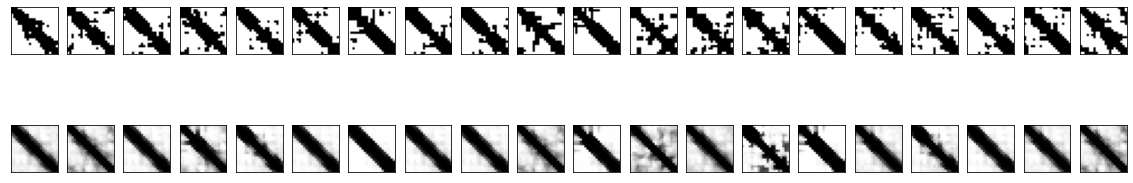

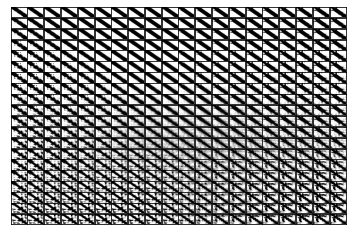

   1: TIME: 48.77 ETA: 4828.40 AE_LOSS: 0.0728 DC_LOSS: 1.3133 DC_ACC: 58.9018 GEN_LOSS: 0.7969
   2: TIME: 57.88 ETA: 5672.00 AE_LOSS: 0.0701 DC_LOSS: 1.3296 DC_ACC: 59.1222 GEN_LOSS: 0.7815
   3: TIME: 49.13 ETA: 4765.57 AE_LOSS: 0.0687 DC_LOSS: 1.3444 DC_ACC: 58.8722 GEN_LOSS: 0.7557
   4: TIME: 44.67 ETA: 4288.58 AE_LOSS: 0.0824 DC_LOSS: 1.4139 DC_ACC: 58.3976 GEN_LOSS: 0.8055
   5: TIME: 82.07 ETA: 7796.53 AE_LOSS: 0.0923 DC_LOSS: 1.4037 DC_ACC: 57.6348 GEN_LOSS: 0.9085
   6: TIME: 82.08 ETA: 7715.55 AE_LOSS: 0.0778 DC_LOSS: 1.3581 DC_ACC: 57.4959 GEN_LOSS: 0.7822
   7: TIME: 82.14 ETA: 7638.59 AE_LOSS: 0.0706 DC_LOSS: 1.3568 DC_ACC: 57.5616 GEN_LOSS: 0.7311
   8: TIME: 82.07 ETA: 7550.29 AE_LOSS: 0.0706 DC_LOSS: 1.3530 DC_ACC: 57.4223 GEN_LOSS: 0.7408
   9: TIME: 82.09 ETA: 7469.94 AE_LOSS: 0.1052 DC_LOSS: 1.5762 DC_ACC: 57.3848 GEN_LOSS: 3.8419
  10: TIME: 82.07 ETA: 7386.35 AE_LOSS: 0.0776 DC_LOSS: 1.3238 DC_ACC: 57.5279 GEN_LOSS: 0.7760


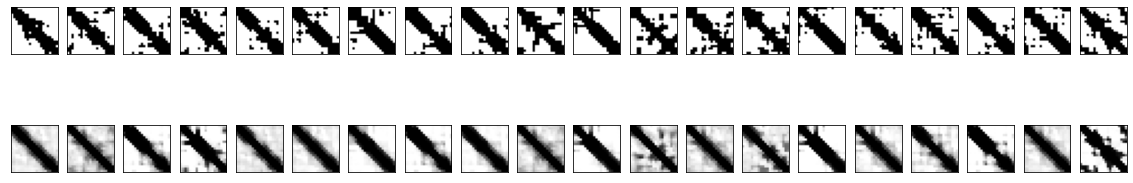

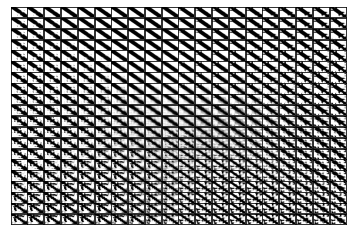

  11: TIME: 45.56 ETA: 4054.96 AE_LOSS: 0.0714 DC_LOSS: 1.3463 DC_ACC: 57.6164 GEN_LOSS: 0.7455
  12: TIME: 45.63 ETA: 4015.39 AE_LOSS: 0.0702 DC_LOSS: 1.3448 DC_ACC: 57.6260 GEN_LOSS: 0.7490
  13: TIME: 47.07 ETA: 4095.20 AE_LOSS: 0.0707 DC_LOSS: 1.3358 DC_ACC: 57.6397 GEN_LOSS: 0.7836
  14: TIME: 46.09 ETA: 3963.47 AE_LOSS: 0.0743 DC_LOSS: 1.3303 DC_ACC: 57.6710 GEN_LOSS: 0.8556
  15: TIME: 45.81 ETA: 3893.51 AE_LOSS: 0.0691 DC_LOSS: 1.3560 DC_ACC: 57.6545 GEN_LOSS: 0.7397
  16: TIME: 47.42 ETA: 3983.68 AE_LOSS: 0.0711 DC_LOSS: 1.3450 DC_ACC: 57.5792 GEN_LOSS: 0.7750
  17: TIME: 82.07 ETA: 6812.09 AE_LOSS: 0.0881 DC_LOSS: 1.4009 DC_ACC: 57.4892 GEN_LOSS: 0.8216
  18: TIME: 46.74 ETA: 3832.68 AE_LOSS: 0.0835 DC_LOSS: 1.3856 DC_ACC: 57.2504 GEN_LOSS: 0.7993
  19: TIME: 47.43 ETA: 3841.51 AE_LOSS: 0.0706 DC_LOSS: 1.3694 DC_ACC: 57.0798 GEN_LOSS: 0.7070
  20: TIME: 46.44 ETA: 3715.60 AE_LOSS: 0.0699 DC_LOSS: 1.3622 DC_ACC: 57.0243 GEN_LOSS: 0.7185


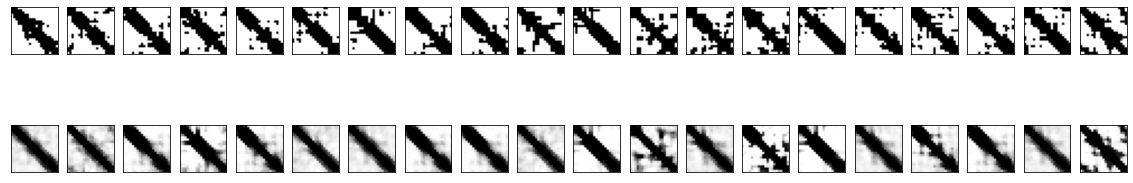

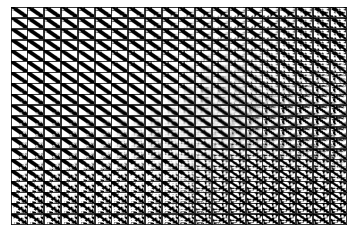

  21: TIME: 82.12 ETA: 6487.31 AE_LOSS: 0.0929 DC_LOSS: 1.4398 DC_ACC: 56.9559 GEN_LOSS: 0.8177
  22: TIME: 47.71 ETA: 3721.67 AE_LOSS: 0.0873 DC_LOSS: 1.4109 DC_ACC: 56.8009 GEN_LOSS: 0.7915
  23: TIME: 46.07 ETA: 3547.46 AE_LOSS: 0.0716 DC_LOSS: 1.3716 DC_ACC: 56.7256 GEN_LOSS: 0.7057
  24: TIME: 46.10 ETA: 3503.56 AE_LOSS: 0.0698 DC_LOSS: 1.3693 DC_ACC: 56.6681 GEN_LOSS: 0.7105
  25: TIME: 82.07 ETA: 6155.54 AE_LOSS: 0.0889 DC_LOSS: 1.4294 DC_ACC: 56.5860 GEN_LOSS: 0.8002
  26: TIME: 82.09 ETA: 6074.42 AE_LOSS: 0.0837 DC_LOSS: 1.4319 DC_ACC: 56.3945 GEN_LOSS: 0.7438
  27: TIME: 47.45 ETA: 3463.73 AE_LOSS: 0.0714 DC_LOSS: 1.3697 DC_ACC: 56.3374 GEN_LOSS: 0.7060
  28: TIME: 46.19 ETA: 3325.85 AE_LOSS: 0.0709 DC_LOSS: 1.3698 DC_ACC: 56.2936 GEN_LOSS: 0.7150
  29: TIME: 82.07 ETA: 5826.89 AE_LOSS: 0.0896 DC_LOSS: 1.3990 DC_ACC: 56.2634 GEN_LOSS: 0.9109
  30: TIME: 82.07 ETA: 5745.12 AE_LOSS: 0.0895 DC_LOSS: 1.5150 DC_ACC: 56.1562 GEN_LOSS: 0.8701


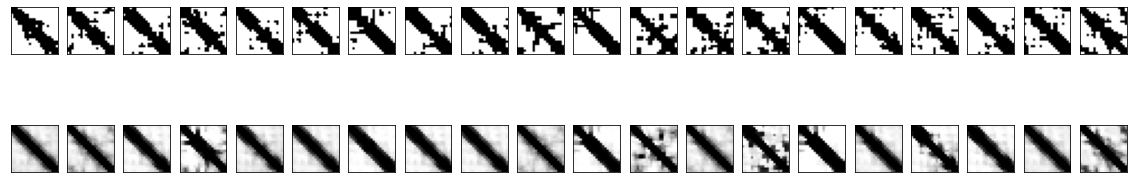

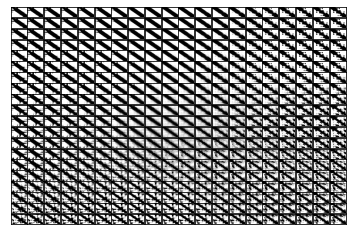

  31: TIME: 46.97 ETA: 3241.09 AE_LOSS: 0.0728 DC_LOSS: 1.3720 DC_ACC: 56.0925 GEN_LOSS: 0.7115
  32: TIME: 46.45 ETA: 3158.76 AE_LOSS: 0.0714 DC_LOSS: 1.3715 DC_ACC: 56.0539 GEN_LOSS: 0.7094
  33: TIME: 82.07 ETA: 5498.51 AE_LOSS: 0.0825 DC_LOSS: 1.3901 DC_ACC: 56.0185 GEN_LOSS: 0.7764
  34: TIME: 82.07 ETA: 5416.85 AE_LOSS: 0.0822 DC_LOSS: 1.3833 DC_ACC: 55.9601 GEN_LOSS: 0.7610
  35: TIME: 47.78 ETA: 3105.56 AE_LOSS: 0.0710 DC_LOSS: 1.3782 DC_ACC: 55.9113 GEN_LOSS: 0.7046
  36: TIME: 46.27 ETA: 2961.40 AE_LOSS: 0.0699 DC_LOSS: 1.3740 DC_ACC: 55.8360 GEN_LOSS: 0.7073
  37: TIME: 45.54 ETA: 2868.84 AE_LOSS: 0.0886 DC_LOSS: 1.4192 DC_ACC: 55.7891 GEN_LOSS: 0.7787
  38: TIME: 47.69 ETA: 2956.76 AE_LOSS: 0.0736 DC_LOSS: 1.3802 DC_ACC: 55.6616 GEN_LOSS: 0.7023
  39: TIME: 46.15 ETA: 2814.99 AE_LOSS: 0.0684 DC_LOSS: 1.3781 DC_ACC: 55.6175 GEN_LOSS: 0.7026
  40: TIME: 82.07 ETA: 4924.16 AE_LOSS: 0.0687 DC_LOSS: 1.3755 DC_ACC: 55.5619 GEN_LOSS: 0.7075


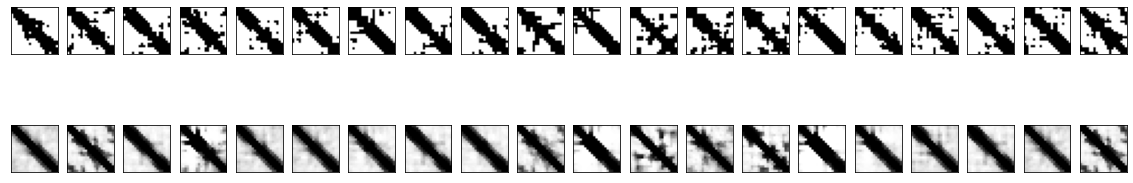

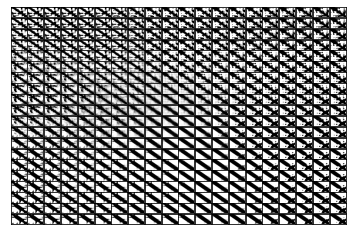

  41: TIME: 82.11 ETA: 4844.25 AE_LOSS: 0.0852 DC_LOSS: 1.3673 DC_ACC: 55.5458 GEN_LOSS: 0.8076
  42: TIME: 46.21 ETA: 2680.23 AE_LOSS: 0.0922 DC_LOSS: 1.4159 DC_ACC: 55.5329 GEN_LOSS: 0.8647
  43: TIME: 47.68 ETA: 2717.65 AE_LOSS: 0.0722 DC_LOSS: 1.3719 DC_ACC: 55.5187 GEN_LOSS: 0.7071
  44: TIME: 46.51 ETA: 2604.33 AE_LOSS: 0.0704 DC_LOSS: 1.3625 DC_ACC: 55.5196 GEN_LOSS: 0.7151
  45: TIME: 45.41 ETA: 2497.31 AE_LOSS: 0.0879 DC_LOSS: 1.4022 DC_ACC: 55.5161 GEN_LOSS: 0.8048
  46: TIME: 45.06 ETA: 2433.15 AE_LOSS: 0.0746 DC_LOSS: 1.3602 DC_ACC: 55.4986 GEN_LOSS: 0.7567
  47: TIME: 82.07 ETA: 4349.53 AE_LOSS: 0.0693 DC_LOSS: 1.3727 DC_ACC: 55.5223 GEN_LOSS: 0.7098
  48: TIME: 44.28 ETA: 2302.32 AE_LOSS: 0.0693 DC_LOSS: 1.3698 DC_ACC: 55.5073 GEN_LOSS: 0.7159
  49: TIME: 44.70 ETA: 2279.94 AE_LOSS: 0.0935 DC_LOSS: 1.4477 DC_ACC: 55.4470 GEN_LOSS: 0.7493
  50: TIME: 82.08 ETA: 4103.88 AE_LOSS: 0.0771 DC_LOSS: 1.3880 DC_ACC: 55.3321 GEN_LOSS: 0.6991


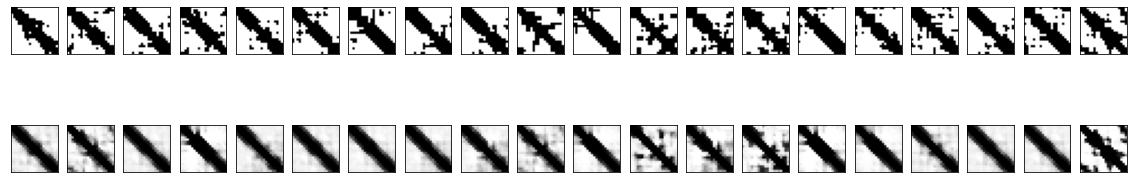

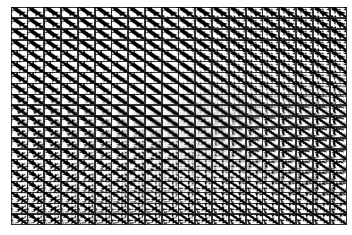

  51: TIME: 45.04 ETA: 2206.97 AE_LOSS: 0.0707 DC_LOSS: 1.3694 DC_ACC: 55.3552 GEN_LOSS: 0.7096
  52: TIME: 82.07 ETA: 3939.15 AE_LOSS: 0.0747 DC_LOSS: 1.3799 DC_ACC: 55.3823 GEN_LOSS: 0.7274
  53: TIME: 82.08 ETA: 3857.67 AE_LOSS: 0.0988 DC_LOSS: 1.5010 DC_ACC: 55.3937 GEN_LOSS: 4.8507
  54: TIME: 82.07 ETA: 3775.17 AE_LOSS: 0.0761 DC_LOSS: 1.3198 DC_ACC: 55.5113 GEN_LOSS: 0.9547
  55: TIME: 82.08 ETA: 3693.57 AE_LOSS: 0.0708 DC_LOSS: 1.3111 DC_ACC: 55.5972 GEN_LOSS: 0.8406
  56: TIME: 47.32 ETA: 2082.10 AE_LOSS: 0.0697 DC_LOSS: 1.3087 DC_ACC: 55.6672 GEN_LOSS: 0.8471
  57: TIME: 82.08 ETA: 3529.40 AE_LOSS: 0.0731 DC_LOSS: 1.2705 DC_ACC: 55.7519 GEN_LOSS: 1.1406
  58: TIME: 45.26 ETA: 1900.81 AE_LOSS: 0.0784 DC_LOSS: 1.3408 DC_ACC: 55.8405 GEN_LOSS: 1.0989
  59: TIME: 82.07 ETA: 3364.72 AE_LOSS: 0.0675 DC_LOSS: 1.3507 DC_ACC: 55.8516 GEN_LOSS: 0.7415
  60: TIME: 82.07 ETA: 3282.74 AE_LOSS: 0.0669 DC_LOSS: 1.3353 DC_ACC: 55.9173 GEN_LOSS: 0.7672


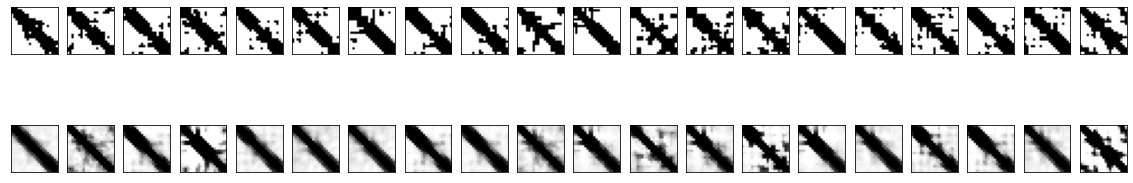

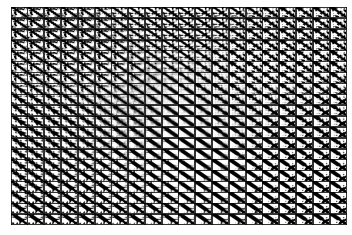

  61: TIME: 82.10 ETA: 3201.94 AE_LOSS: 0.0713 DC_LOSS: 1.3227 DC_ACC: 55.9657 GEN_LOSS: 0.8579
  62: TIME: 82.07 ETA: 3118.52 AE_LOSS: 0.0710 DC_LOSS: 1.3420 DC_ACC: 55.9972 GEN_LOSS: 0.7983
  63: TIME: 46.10 ETA: 1705.83 AE_LOSS: 0.0663 DC_LOSS: 1.3639 DC_ACC: 56.0104 GEN_LOSS: 0.7330
  64: TIME: 82.07 ETA: 2954.52 AE_LOSS: 0.0673 DC_LOSS: 1.3579 DC_ACC: 56.0058 GEN_LOSS: 0.7442
  65: TIME: 47.62 ETA: 1666.63 AE_LOSS: 0.0904 DC_LOSS: 1.4184 DC_ACC: 56.0086 GEN_LOSS: 0.8930
  66: TIME: 82.07 ETA: 2790.41 AE_LOSS: 0.0825 DC_LOSS: 1.3865 DC_ACC: 55.9787 GEN_LOSS: 0.7587
  67: TIME: 45.04 ETA: 1486.18 AE_LOSS: 0.0698 DC_LOSS: 1.3767 DC_ACC: 55.9403 GEN_LOSS: 0.7020
  68: TIME: 48.29 ETA: 1545.40 AE_LOSS: 0.0689 DC_LOSS: 1.3697 DC_ACC: 55.9286 GEN_LOSS: 0.7139
  69: TIME: 82.08 ETA: 2544.38 AE_LOSS: 0.0890 DC_LOSS: 1.4295 DC_ACC: 55.9179 GEN_LOSS: 0.8112
  70: TIME: 47.45 ETA: 1423.38 AE_LOSS: 0.0802 DC_LOSS: 1.3840 DC_ACC: 55.8742 GEN_LOSS: 0.7498


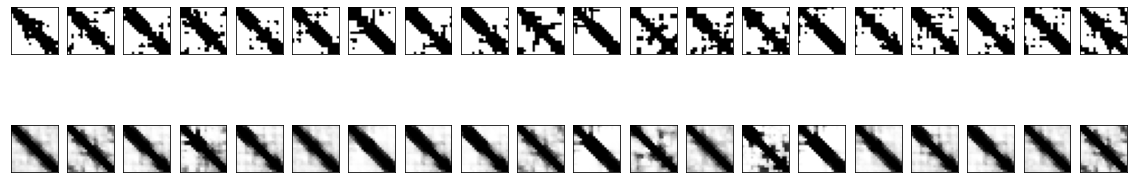

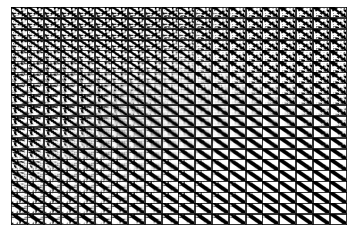

  71: TIME: 82.10 ETA: 2380.94 AE_LOSS: 0.0702 DC_LOSS: 1.3752 DC_ACC: 55.8623 GEN_LOSS: 0.7075
  72: TIME: 82.07 ETA: 2297.97 AE_LOSS: 0.0698 DC_LOSS: 1.3751 DC_ACC: 55.8336 GEN_LOSS: 0.7128
  73: TIME: 45.07 ETA: 1217.02 AE_LOSS: 0.0958 DC_LOSS: 1.4272 DC_ACC: 55.8268 GEN_LOSS: 0.8885
  74: TIME: 45.08 ETA: 1172.15 AE_LOSS: 0.0781 DC_LOSS: 1.3824 DC_ACC: 55.8114 GEN_LOSS: 0.7326
  75: TIME: 46.02 ETA: 1150.60 AE_LOSS: 0.0701 DC_LOSS: 1.3704 DC_ACC: 55.8107 GEN_LOSS: 0.7123
  76: TIME: 82.07 ETA: 1969.76 AE_LOSS: 0.0696 DC_LOSS: 1.3712 DC_ACC: 55.7956 GEN_LOSS: 0.7144
  77: TIME: 45.05 ETA: 1036.23 AE_LOSS: 0.0903 DC_LOSS: 1.4721 DC_ACC: 55.7805 GEN_LOSS: 0.8467
  78: TIME: 47.09 ETA: 1036.03 AE_LOSS: 0.0708 DC_LOSS: 1.3722 DC_ACC: 55.7584 GEN_LOSS: 0.7139
  79: TIME: 46.51 ETA: 976.76 AE_LOSS: 0.0675 DC_LOSS: 1.3784 DC_ACC: 55.7430 GEN_LOSS: 0.7048
  80: TIME: 47.28 ETA: 945.50 AE_LOSS: 0.0676 DC_LOSS: 1.3735 DC_ACC: 55.7210 GEN_LOSS: 0.7091


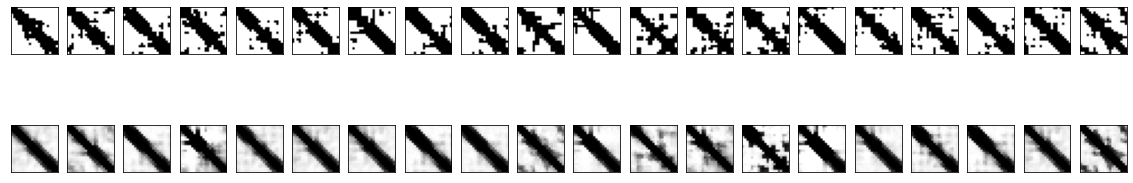

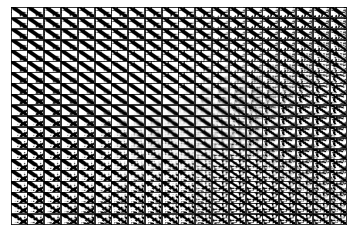

  81: TIME: 47.24 ETA: 897.64 AE_LOSS: 0.0953 DC_LOSS: 1.4687 DC_ACC: 55.7021 GEN_LOSS: 0.8573
  82: TIME: 82.08 ETA: 1477.42 AE_LOSS: 0.0883 DC_LOSS: 1.3890 DC_ACC: 55.6464 GEN_LOSS: 0.7696
  83: TIME: 82.07 ETA: 1395.19 AE_LOSS: 0.0718 DC_LOSS: 1.3817 DC_ACC: 55.5837 GEN_LOSS: 0.6958
  84: TIME: 45.75 ETA: 731.99 AE_LOSS: 0.0707 DC_LOSS: 1.3686 DC_ACC: 55.5911 GEN_LOSS: 0.7091
  85: TIME: 82.07 ETA: 1231.00 AE_LOSS: 0.0855 DC_LOSS: 1.3975 DC_ACC: 55.5958 GEN_LOSS: 0.7945
  86: TIME: 49.40 ETA: 691.61 AE_LOSS: 0.0776 DC_LOSS: 1.3862 DC_ACC: 55.5590 GEN_LOSS: 0.7141
  87: TIME: 82.07 ETA: 1066.93 AE_LOSS: 0.0700 DC_LOSS: 1.3750 DC_ACC: 55.5571 GEN_LOSS: 0.7119
  88: TIME: 82.08 ETA: 984.90 AE_LOSS: 0.0697 DC_LOSS: 1.3722 DC_ACC: 55.5427 GEN_LOSS: 0.7110
  89: TIME: 48.52 ETA: 533.71 AE_LOSS: 0.0919 DC_LOSS: 1.3829 DC_ACC: 55.5549 GEN_LOSS: 0.9825
  90: TIME: 82.07 ETA: 820.67 AE_LOSS: 0.0891 DC_LOSS: 1.4439 DC_ACC: 55.5216 GEN_LOSS: 0.9104


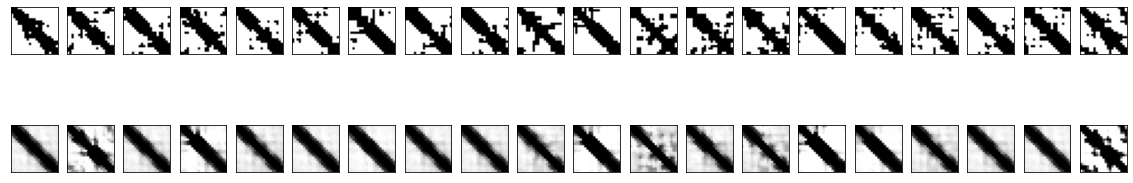

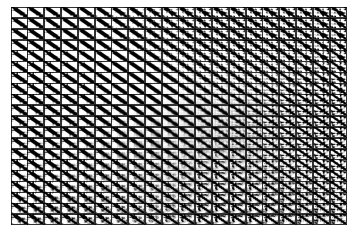

  91: TIME: 82.10 ETA: 738.86 AE_LOSS: 0.0724 DC_LOSS: 1.3367 DC_ACC: 55.5308 GEN_LOSS: 0.7463
  92: TIME: 82.07 ETA: 656.59 AE_LOSS: 0.0710 DC_LOSS: 1.3388 DC_ACC: 55.5680 GEN_LOSS: 0.7596
  93: TIME: 82.07 ETA: 574.47 AE_LOSS: 0.0831 DC_LOSS: 1.3926 DC_ACC: 55.5911 GEN_LOSS: 0.8469
  94: TIME: 82.07 ETA: 492.41 AE_LOSS: 0.0815 DC_LOSS: 1.3733 DC_ACC: 55.5886 GEN_LOSS: 0.7875
  95: TIME: 45.87 ETA: 229.34 AE_LOSS: 0.0692 DC_LOSS: 1.3608 DC_ACC: 55.6151 GEN_LOSS: 0.7330
  96: TIME: 47.06 ETA: 188.26 AE_LOSS: 0.0692 DC_LOSS: 1.3565 DC_ACC: 55.6168 GEN_LOSS: 0.7460
  97: TIME: 48.53 ETA: 145.59 AE_LOSS: 0.0933 DC_LOSS: 1.4610 DC_ACC: 55.6129 GEN_LOSS: 0.8001
  98: TIME: 82.07 ETA: 164.13 AE_LOSS: 0.0828 DC_LOSS: 1.4140 DC_ACC: 55.5638 GEN_LOSS: 0.7251
  99: TIME: 82.07 ETA: 82.07 AE_LOSS: 0.0712 DC_LOSS: 1.3737 DC_ACC: 55.5406 GEN_LOSS: 0.7046


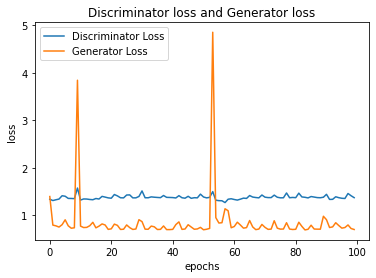

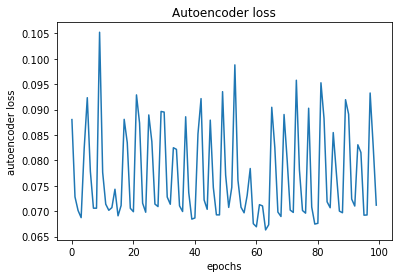

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Training function
@tf.function
def train_step(batch_x):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(encoder_output, training=True)

        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], latent_dim], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, gen_loss_weight)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss


# -------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
dcloss = []
genloss = []
aeloss = []
for epoch in range(n_epochs):
    start = time.time()
    #calculate the loss
    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()


    for batch, (batch_x) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        # calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
        ae_optimizer.lr = clr
        dc_optimizer.lr = clr
        gen_optimizer.lr = clr

        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)
    
    #add the loss result to the list
    dcloss.append(epoch_dc_loss_avg.result())
    genloss.append(epoch_gen_loss_avg.result())
    aeloss.append(epoch_ae_loss_avg.result())
    epoch_time = time.time() - start
    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  100*epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
    
    # -------------------------------------------------------------------------------------------------------------
    if epoch % 10 == 0:

        # Reconstruction
        n_digits = 20  # how many digits we will display
        x_test_decoded = decoder(encoder(test[:n_digits], training=False), training=False)
        x_test_decoded = np.reshape(x_test_decoded, [-1, 21, 21]) * 255
        fig = plt.figure(figsize=(20, 4))
        for i in range(n_digits):
            # display original
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(test[i].reshape(21, 21))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(x_test_decoded[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        plt.show()

        # Sampling
        x_points = np.linspace(-3, 3, 20).astype(np.float32)
        y_points = np.linspace(-3, 3, 20).astype(np.float32)

        nx, ny = len(x_points), len(y_points)
        plt.subplot()
        gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

        for i, g in enumerate(gs):
            z = np.concatenate(([x_points[int(i / ny)]], [y_points[int(i % nx)]]))
            z = np.reshape(z, (1, 2))
            x = decoder(z, training=False).numpy()
            ax = plt.subplot(g)
            img = np.array(x.tolist()).reshape(21, 21)
            ax.imshow(img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')
        plt.show()
        
#plot the loss function images
t = np.arange(0, n_epochs, 1)
plt.title("Discriminator loss and Generator loss")
plt.plot(t, dcloss)
plt.plot(t, genloss)  
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['Discriminator Loss', 'Generator Loss'], loc = 'upper left')
plt.show()

plt.title("Autoencoder loss")
plt.plot(t, aeloss)
plt.xlabel("epochs")
plt.ylabel("autoencoder loss")
plt.show()